In [1]:
import torch
from torch.autograd import Variable
import numpy as np
import random
import scipy.special
import os
import json
import collections
import re
import pickle
import matplotlib.pyplot as plt

In [2]:
SRC_DIR = "./MLDS_hw2_1_data"

<h4> Pre-process Data </h4>

In [3]:
def indexSentence(sentence, frequency, indexOfWord):
    indicesList = [indexOfWord['<BOS>']]

    for word in sentence.split():
        indicesList.append(indexOfWord.get(word, indexOfWord['<UNK>']))

    indicesList.append(indexOfWord['<EOS>'])
    return indicesList

def annotate(labelFilePath, frequency, indexOfWord):
    captions = []

    with open(os.path.join(SRC_DIR, labelFilePath), 'r') as f:
        labels = json.load(f)
        
    for entry in labels:
        entryId = entry['id']
        for sentence in entry['caption']:
            annotatedIndices = indexSentence(sentence, frequency, indexOfWord)
            captions.append((entryId, annotatedIndices))

    return captions

def extractWordsFromFile(fileName = 'training_label.json'):
    with open(os.path.join(SRC_DIR, fileName), 'r') as f:
        data = json.load(f)

    frequency = {}

    for item in data:
        for sentence in item['caption']:
            words = sentence.split()
            for word in words:
                if word in frequency:
                    frequency[word] += 1
                else:
                    frequency[word] = 1

    words = list(frequency.keys()) + ['<PAD>', '<BOS>', '<EOS>', '<UNK>']
    
    indexOfWord = {}
    wordOfIndex = {}
    for index, word in enumerate(words):
        indexOfWord[word] = index
    
    for word, index in indexOfWord.items():
        wordOfIndex[index] = word

    return wordOfIndex, indexOfWord, frequency

In [4]:
class TrainingDataset(torch.utils.data.Dataset):
    def __init__(self, aviFiles, labelsFile, frequency, indexOfWord):
        self.aviData = self.loadFilesData(aviFiles)
        self.dataPairs = annotate(labelsFile, frequency, indexOfWord)

    def __len__(self):
        return len(self.dataPairs)

    def __getitem__(self, idx):
        aviFileName, sentence = self.dataPairs[idx]
        aviData = torch.Tensor(self.aviData[aviFileName])
        noise = torch.rand_like(aviData) * 0.0002
        noisyData = aviData + noise

        return noisyData, torch.LongTensor(sentence)

    def loadFilesData(self, filesDir):
        aviData = {}
        trainingFeatsDir = os.path.join(SRC_DIR, filesDir)
        fileList = os.listdir(trainingFeatsDir)

        for i, fileName in enumerate(fileList):
            filePath = os.path.join(trainingFeatsDir, fileName)
            value = np.load(filePath)
            key = fileName.split('.npy')[0]
            aviData[key] = value

        return aviData

<h4> Attention Model </h4>

In [5]:
class Attention(torch.nn.Module):
    def __init__(self, dimension):
        super(Attention, self).__init__()
        self.dimension = dimension

        self.firstLayer = torch.nn.Linear(2 * dimension, dimension)
        self.secondLayer = torch.nn.Linear(dimension, dimension)
        self.thirdLayer = torch.nn.Linear(dimension, dimension)
        self.fourthLayer = torch.nn.Linear(dimension, dimension)
        self.fifthLayer = torch.nn.Linear(dimension, dimension)
    
        self.linearLayer = torch.nn.Linear(dimension, 1, bias=False)

    def forward(self, hiddenState, encoderOutputs):
        batchSize, seqLen, featureCount = encoderOutputs.size()
        hiddenState = hiddenState.view(batchSize, 1, featureCount).repeat(1, seqLen, 1)
        matchingInputs = torch.cat((encoderOutputs, hiddenState), 2).view(-1, 2 * self.dimension)

        x = self.firstLayer(matchingInputs)
        x = self.secondLayer(x)
        x = self.thirdLayer(x)
        x = self.fourthLayer(x)
        x = self.fifthLayer(x)

        attentionWeights = self.linearLayer(x)
        attentionWeights = attentionWeights.view(batchSize, seqLen)
        attentionWeights = torch.nn.functional.softmax(attentionWeights, dim=1)
        context = torch.bmm(attentionWeights.unsqueeze(1), encoderOutputs).squeeze(1)

        return context

<h4> Encoder </h4>

In [6]:
class Encoder(torch.nn.Module):
    def __init__(self, inputSize=4096, hiddenSize=256, numLayers=1, dropout=0.30):
        super(Encoder, self).__init__()
        self.embeddingLayer = torch.nn.Linear(inputSize, hiddenSize)
        self.dropoutLayer = torch.nn.Dropout(dropout)
        self.lstmLayer = torch.nn.LSTM(hiddenSize, hiddenSize, num_layers=numLayers, batch_first=True)

    def forward(self, input):
        batchSize, seqLen, featureCount = input.size()
        input = input.view(-1, featureCount)
        embeddedInput = self.embeddingLayer(input)
        embeddedInput = self.dropoutLayer(embeddedInput)
        embeddedInput = embeddedInput.view(batchSize, seqLen, -1)
        output, (hiddenState, cellState) = self.lstmLayer(embeddedInput)
        return output, hiddenState

<h4> Decoder </h4>

In [7]:
class Decoder(torch.nn.Module):
    def __init__(self, hiddenSize, outputSize, vocabSize, wordDim, dropoutPercentage=0.30):
        super(Decoder, self).__init__()

        self.hiddenSize = hiddenSize
        self.outputSize = outputSize
        self.vocabSize = vocabSize
        self.wordDim = wordDim

        self.embeddingLayer = torch.nn.Embedding(outputSize, wordDim)
        self.dropoutLayer = torch.nn.Dropout(dropoutPercentage)
        self.lstmLayer = torch.nn.LSTM(hiddenSize + wordDim, hiddenSize, batch_first=True)
        self.attentionLayer = Attention(hiddenSize)
        self.finalOutputLayer = torch.nn.Linear(hiddenSize, vocabSize)

    def forward(self, encoderLastHiddenState, encoderOutput, targets=None, mode='train', trainingSteps=None):
        batchSize = encoderLastHiddenState.size(1)

        decoderCurrentHiddenState = None if encoderLastHiddenState is None else encoderLastHiddenState
        decoderContext = torch.zeros(decoderCurrentHiddenState.size()).cuda()

        decoderCurrentInputWord = Variable(torch.ones(batchSize, 1)).long().cuda()
        seqLogProb = []
        seqPredictions = []

        targets = self.embeddingLayer(targets)
        seqLen = targets.size(1)

        for i in range(seqLen - 1):
            threshold = scipy.special.expit(trainingSteps / 20 + 0.85)
            if random.uniform(0.05, 0.995) > threshold:
                currentInputWord = targets[:, i]
            else:
                currentInputWord = self.embeddingLayer(decoderCurrentInputWord).squeeze(1)

            context = self.attentionLayer(decoderCurrentHiddenState, encoderOutput)
            lstmInput = torch.cat([currentInputWord, context], dim=1).unsqueeze(1)
            lstmOutput, t = self.lstmLayer(lstmInput, (decoderCurrentHiddenState, decoderContext))
            decoderCurrentHiddenState = t[0]
            logProb = self.finalOutputLayer(lstmOutput.squeeze(1))
            seqLogProb.append(logProb.unsqueeze(1))
            decoderCurrentInputWord = logProb.unsqueeze(1).max(2)[1]

        seqLogProb = torch.cat(seqLogProb, dim=1)
        seqPredictions = seqLogProb.max(2)[1]
        return seqLogProb, seqPredictions

    def inference(self, encoderLastHiddenState, encoderOutput):
        batchSize = encoderLastHiddenState.size(1)
        decoderCurrentHiddenState = None if encoderLastHiddenState is None else encoderLastHiddenState
        decoderCurrentInputWord = Variable(torch.ones(batchSize, 1)).long().cuda()
        decoderContext = torch.zeros(decoderCurrentHiddenState.size()).cuda()
        seqLogProb = []
        seqPredictions = []
        assumptionSeqLen = 28

        for i in range(assumptionSeqLen - 1):
            currentInputWord = self.embeddingLayer(decoderCurrentInputWord).squeeze(1)
            context = self.attentionLayer(decoderCurrentHiddenState, encoderOutput)
            lstmInput = torch.cat([currentInputWord, context], dim=1).unsqueeze(1)
            lstmOutput, t = self.lstmLayer(lstmInput, (decoderCurrentHiddenState, decoderContext))
            decoderCurrentHiddenState = t[0]
            logProb = self.finalOutputLayer(lstmOutput.squeeze(1))
            seqLogProb.append(logProb.unsqueeze(1))
            decoderCurrentInputWord = logProb.unsqueeze(1).max(2)[1]

        seqLogProb = torch.cat(seqLogProb, dim=1)
        seqPredictions = seqLogProb.max(2)[1]
        return seqLogProb, seqPredictions

In [8]:
class Models(torch.nn.Module):
    def __init__(self, encoder, decoder):
        super(Models, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, aviFeat, mode, targetSentences=None, trainingSteps=None):
        encoderOutputs, encoderLastHiddenState = self.encoder(aviFeat)

        if mode == 'train':
            seqLogProb, seqPredictions = self.decoder(
                encoderLastHiddenState=encoderLastHiddenState,
                encoderOutput=encoderOutputs,
                targets=targetSentences,
                mode=mode,
                trainingSteps=trainingSteps
            )
        elif mode == 'inference':
            seqLogProb, seqPredictions = self.decoder.inference(
                encoderLastHiddenState=encoderLastHiddenState,
                encoderOutput=encoderOutputs
            )

        return seqLogProb, seqPredictions

<h4> Training </h4>

In [9]:
def calculateLoss(lossFn, predictions, targets, lengths):
    batchSize = len(predictions)
    predictedConcat = []
    groundTruthConcat = []

    for batch in range(batchSize):
        predicted = predictions[batch][:lengths[batch] - 1]
        groundTruth = targets[batch][:lengths[batch] - 1]
        predictedConcat.append(predicted)
        groundTruthConcat.append(groundTruth)

    predictedConcat = torch.cat(predictedConcat, dim=0)
    groundTruthConcat = torch.cat(groundTruthConcat, dim=0)

    loss = lossFn(predictedConcat, groundTruthConcat)
    avgLoss = loss / batchSize

    return avgLoss

def train(model, epoch, lossFn, optimizer, trainLoader):
    model.train()
    model = model.cuda()
    totalLoss = 0.0
    totalBatches = len(trainLoader)

    for batchIdx, batch in enumerate(trainLoader):
        aviFeats, groundTruths, lengths = batch[0].cuda(), batch[1].cuda(), batch[2]

        optimizer.zero_grad()
        seqLogProb, seqPredictions = model(aviFeats, targetSentences=groundTruths, mode='train', trainingSteps=epoch)
        groundTruths = groundTruths[:, 1:]

        loss = calculateLoss(lossFn, seqLogProb, groundTruths, lengths)
        totalLoss += loss.item()

        loss.backward()
        optimizer.step()

    averageLoss = totalLoss / totalBatches
    print('Epoch:', epoch, 'Average Loss =', averageLoss)
    return averageLoss

In [10]:
LEARNING_RATE = 0.0001
EPOCHS = 50
BATCH_SIZE = 64
DIMENSION = 256
DROPOUT_RATE = 0.30

def miniBatch(data):
    data.sort(key=lambda x: len(x[1]), reverse=True)
    aviData, captions = zip(*data)
    aviData = torch.stack(aviData, 0)
    lengths = [len(cap) for cap in captions]
    targets = torch.zeros(len(captions), max(lengths)).long()
    
    for i, cap in enumerate(captions):
        end = lengths[i]
        targets[i, :end] = cap[:end]
    
    return aviData, targets, lengths

def main():
    wordOfIndex, indexOfWord, frequency = extractWordsFromFile('training_label.json')
    with open('wordOfIndex.pickle', 'wb') as handle:
        pickle.dump(wordOfIndex, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    trainDataset = TrainingDataset('training_data/feat', 'training_label.json', frequency, indexOfWord)
    trainDataLoader = torch.utils.data.DataLoader(
        dataset=trainDataset, 
        batch_size=BATCH_SIZE, 
        shuffle=True, 
        num_workers=8, 
        collate_fn=miniBatch
    )

    epochs = EPOCHS
    encoder = Encoder()
    decoder = Decoder(DIMENSION, len(wordOfIndex) + 4, len(wordOfIndex) + 4, 1024, DROPOUT_RATE)
    model = Models(encoder=encoder, decoder=decoder)
    model = model.cuda()
    
    lossFn = torch.nn.CrossEntropyLoss()
    parameters = model.parameters()
    optimizer = torch.optim.Adam(parameters, lr=LEARNING_RATE)
    
    lossArr = []
    for epoch in range(epochs):
        loss = train(model, epoch + 1, lossFn, optimizer, trainDataLoader)
        lossArr.append(loss)
    
    with open('lossValues.txt', 'w') as f:
        for item in lossArr:
            f.write("%s\n" % item)
    
    torch.save(model, "{}.h5".format('model'))
    print("Training Complete")

main()

Epoch: 1 Average Loss = 0.08958970951923909
Epoch: 2 Average Loss = 0.07251252119962646
Epoch: 3 Average Loss = 0.07069358146088418
Epoch: 4 Average Loss = 0.06969747173361539
Epoch: 5 Average Loss = 0.06882507898562187
Epoch: 6 Average Loss = 0.0680317924625798
Epoch: 7 Average Loss = 0.06680696906821709
Epoch: 8 Average Loss = 0.06530258088989434
Epoch: 9 Average Loss = 0.06422531894730074
Epoch: 10 Average Loss = 0.06306642390256821
Epoch: 11 Average Loss = 0.06182423534761318
Epoch: 12 Average Loss = 0.06077490354787391
Epoch: 13 Average Loss = 0.06007011900201322
Epoch: 14 Average Loss = 0.05926893007668782
Epoch: 15 Average Loss = 0.0582379012474284
Epoch: 16 Average Loss = 0.05766402498516684
Epoch: 17 Average Loss = 0.05685311614837999
Epoch: 18 Average Loss = 0.05627859206894771
Epoch: 19 Average Loss = 0.055459012161930506
Epoch: 20 Average Loss = 0.05488975965331915
Epoch: 21 Average Loss = 0.054263611041540205
Epoch: 22 Average Loss = 0.053636157054621186
Epoch: 23 Average 

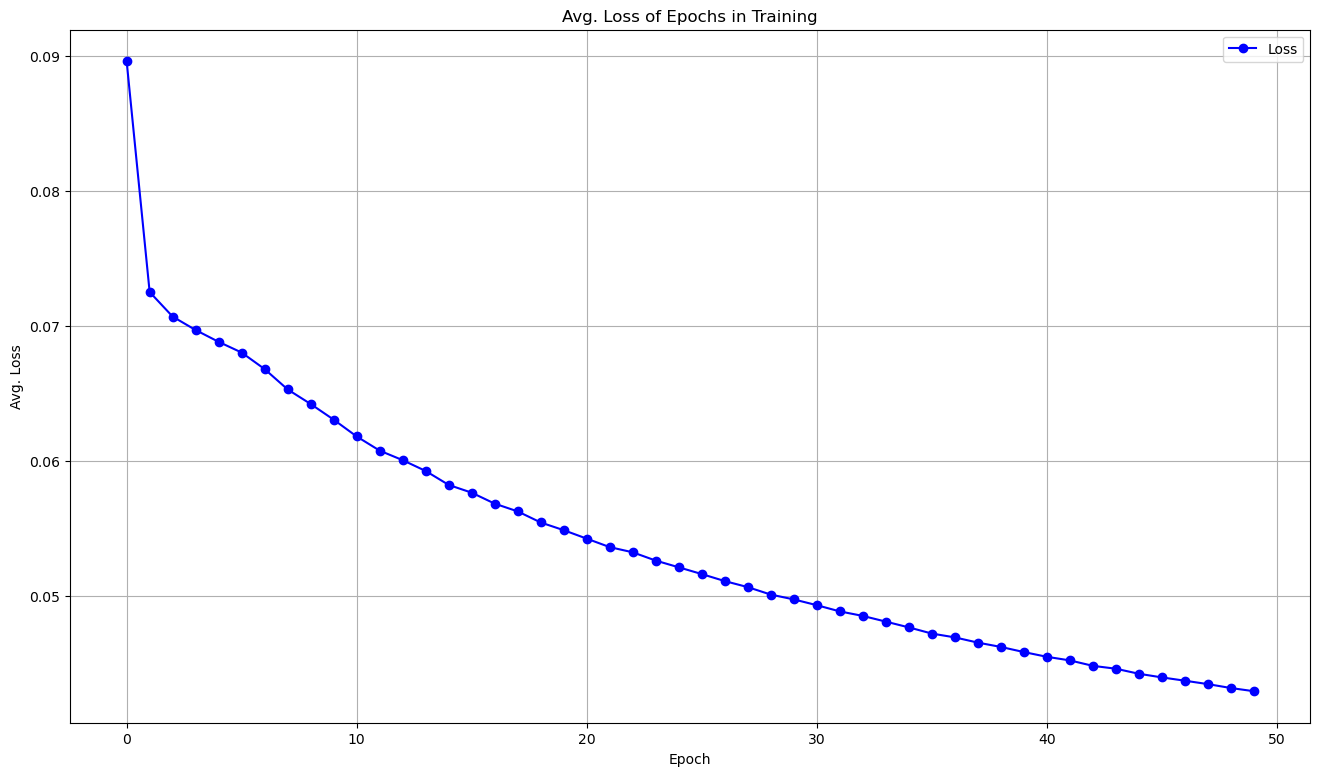

In [11]:
with open('lossValues.txt', 'r') as file:
    lines = file.readlines()
    losses = [float(line.strip()) for line in lines]

plt.figure(figsize=(16, 9))
plt.plot(losses, marker='o', color='b', label='Loss')
plt.title('Avg. Loss of Epochs in Training')
plt.xlabel('Epoch')
plt.ylabel('Avg. Loss')
plt.grid(True)
plt.legend()
plt.show()